# AULA 14: EXERCÍCIO

## OBJETIVO
1. Implementar uma regressão linear múltipla (RLM) para prever consumo de combustível.

2. Otimizar a RLM via tratamento de dados, seleção/engenharia de atributos e regularização, avaliando impacto nas métricas.

## DATASET

Links para acessar o dataset:
* UCI (dados): https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data
* UCI (documentação): https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names

**Alternativa**: utilizar o módulo `ucimlrepo`.

```bash
!pip install ucimlrepo
```


```python
from ucimlrepo import fetch_ucirepo
auto_mpg = fetch_ucirepo(id=9)
X = auto_mpg.data.features
y = auto_mpg.data.targets
```

__UCI — Auto MPG__: cada linha descreve um automóvel (anos 1970–80). Principais colunas:
* __mpg__ — milhas por galão.
* __cylinders__ — número de cilindros (inteiro).
* __displacement__ — cilindrada do motor (in³, polegadas cúbicas).
* __horsepower__ — potência (hp).
*__weight__ — peso do veículo (libras).
* __acceleration__ — tempo 0–60 mph (segundos).
* __model year__ — ano do modelo (entre os anos 70–82).
* __origin__ — região de origem (1=EUA, 2=Europa, 3=Japão).

## <span fontsize=16, style="color: lime;">IMPLEMENTAÇÃO</span>

<span fontsize=16, style="color: #F6CCFF;"> obs: colori os comandos de verde para diferenciar das minhas notas (lilás) </span>

### <span fontsize=16, style="color: lime;"> 0. Bibliotecas </span>

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### <span fontsize=16, style="color: lime;"> 1. Importação e inspeção dos dados </span>


<span fontsize=16, style="color: lime;"> Carregue o Auto MPG (UCI). </span>

In [77]:

df = pd.read_csv('auto-mpg.data', delim_whitespace=True, names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name'])
df

C:\Users\Vinícius Abdon\AppData\Local\Temp\ipykernel_12836\3898162515.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('auto-mpg.data', delim_whitespace=True, names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name'])


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.00,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.00,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.00,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.00,2625.0,18.6,82,1,ford ranger


In [78]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

#### <span fontsize=16, style="color: lime;"> Perguntas</span>
<span style="color: lime;">1. Quais variáveis têm dados faltantes? Qual sua estratégia de imputação/remoção e por quê?</span>

<span style="color: lime">2. Há tipos incorretos? Mostre a correção.</span>

<span fontsize=16, style="color: #F6CCFF;">  Tive problemas na importação dos dados por conta da quantidade de espaços separando as colunas, então acho muito estranho não haverem valores nulos. Olhando o arquivo ``.data`` vi que tem um valor estranho na coluna `horsepower`. </span>

In [79]:
df.at[32, 'horsepower']

'?'

In [80]:
df[df['horsepower'] == '?'][['horsepower', 'model year', 'car name']]

,horsepower,model year,car name
32,?,71,ford pinto
126,?,74,ford maverick
330,?,80,renault lecar deluxe
336,?,80,ford mustang cobra
354,?,81,renault 18i
374,?,82,amc concord dl


<span fontsize=16, style="color: #F6CCFF"> Isso bate com o que a pessoa que publicou o dataset informa no fim do arquivo `auto-mpg.names`, no qual diz haverem 6 valores faltando em `horsepower`

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


<span fontsize=16, style="color: #F6CCFF"> `horsepower` deveria ser do tipo numérico, mas não é por conta dos valores faltantes definidos como `?`

<span fontsize=16, style="color: #F6CCFF"> Para substituir os valores faltantes em `horsepower` vou ver os valores dessa coluna nos outros carros de mesmo modelo no dataset e substituir pela mediana dos valores. Mas, antes disso, preciso atribuir `NaN` no lugar de `?` para poder converter a coluna para valores numéricos</span> 

In [82]:
df.loc[df['horsepower'] == '?', 'horsepower'] = np.nan
df['horsepower'] = df['horsepower'].astype('float')

In [83]:
df[df['car name'] == 'ford pinto'][['horsepower', 'model year', 'car name']]

,horsepower,model year,car name
32,NaN,71,ford pinto
112,85.0,73,ford pinto
130,80.0,74,ford pinto
168,83.0,75,ford pinto
174,97.0,75,ford pinto
206,72.0,76,ford pinto


In [84]:
names = np.array(df[df['horsepower'].isna()]['car name'])
names

array(['ford pinto', 'ford maverick', 'renault lecar deluxe',
       'ford mustang cobra', 'renault 18i', 'amc concord dl'],
      dtype=object)

In [85]:
for name in names:
    mediana = df[df['car name'] == name]['horsepower'].median()
    argumento = (df['car name'] == name) & (df['horsepower'].isna())
    df.loc[argumento, 'horsepower'] = mediana
    print(f"Substituindo NaN por {mediana:.2f} para {name}")

Substituindo NaN por 83.00 para ford pinto
Substituindo NaN por 83.00 para ford maverick
Substituindo NaN por nan para renault lecar deluxe
Substituindo NaN por nan para ford mustang cobra
Substituindo NaN por nan para renault 18i
Substituindo NaN por nan para amc concord dl


c:\Users\Vinícius Abdon\OneDrive - Associacao Cultural e Educacional do Para\6º Semestre\Estatistica\Multiple-Linear-Regression-04-11-25\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Vinícius Abdon\OneDrive - Associacao Cultural e Educacional do Para\6º Semestre\Estatistica\Multiple-Linear-Regression-04-11-25\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Vinícius Abdon\OneDrive - Associacao Cultural e Educacional do Para\6º Semestre\Estatistica\Multiple-Linear-Regression-04-11-25\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Vinícius Abdon\OneDrive - Associacao Cultural e Educacional do Para\6º Semestre\Estatistica\Multiple-Linear-Regress

<span fontsize=16, style="color: #F6CCFF"> Alguns campos ainda se mantiveram como ``NaN``, provavelmente porque só há 1 carro com do modelo, o que tira a possibilidade de usarmos outros dados de carros do mesmo modelo para substituir. Nesse caso vou tirar uma mediana dos carros do mesmo ano para substituir. </span> 

In [86]:
names = df[df['horsepower'].isna()]['car name'].unique()
for name in names:
    # Encontra o ano e verifica se 'horsepower' é NaN para o carro em questão
    row_with_nan = df[(df['car name'] == name) & (df['horsepower'].isna())]
    
    if not row_with_nan.empty:
        year = row_with_nan['model year'].iloc[0]

        # Calcula a mediana para AQUELE ano específico
        mediana_do_ano = df[df['model year'] == year]['horsepower'].median()

        # Substitui o valor
        condicao = (df['car name'] == name) & (df['model year'] == year) & (df['horsepower'].isna())
        df.loc[condicao, 'horsepower'] = mediana_do_ano
        
        print(f"Substituindo NaN por {mediana_do_ano:.2f} para {name} (Ano: {year})")



Substituindo NaN por 75.00 para renault lecar deluxe (Ano: 80)
Substituindo NaN por 75.00 para ford mustang cobra (Ano: 80)
Substituindo NaN por 75.50 para renault 18i (Ano: 81)
Substituindo NaN por 84.00 para amc concord dl (Ano: 82)


<span fontsize=16, style="color: #F6CCFF"> Não sei se tinha outra maneira de fazer isso, mas, geralmente, se você está iterando por um DF no Pandas, provavelmente tem uma maneira melhor de fazer o que você está fazendo usando algum método já existente no Pandas. Como não consegui pensar em outra solução, por curiosidade, perguntei para a IA como ela faria e ela me deu a seguinte resposta: </span> 
```
    df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce') 

    median_by_year = df.groupby('model year')['horsepower'].transform('median')

    df['horsepower'] = df['horsepower'].fillna(median_by_year)

    # Verificação Final

    nan_count = df['horsepower'].isna().sum()
    if nan_count == 0:
        print("✅ Todos os valores 'NaN' em 'horsepower' foram imputados.")
    else:
        print(f"⚠️ Ainda restam {nan_count} NaNs em 'horsepower'.")
```
<span fontsize=16, style="color: #F6CCFF"> Deixei a minha lógica no código final para ser fiel ao que o meu raciocínio foi capaz de pensar. Vou tentar lembrar do transform para uma próxima </span> 

<span fontsize=16, style="color: #F6CCFF"> Continuando: 

<span fontsize=16, style="color: #F6CCFF"> Sei que fui bastante específico nas substituições, mas fiz isso pois o dataset é pequeno, então os poucos dados que existem são muito importantes para quando formos implementar a regressão múltipla.</span> 

### <span fontsize=16, style="color: lime;"> Tratamento e AED </span>

* <span fontsize=16, style="color: lime;"> Remova duplicatas se houver. </span>
* <span fontsize=16, style="color: lime;"> Converta origin para categórica (dummies) **ou** mantenha numérico (justificando escolha). </span>
* <span fontsize=16, style="color: lime;"> Avalie estatísticas descritivas e distribuições. </span>

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


<span fontsize=16, style="color: #F6CCFF"> Analisando as colunas, cheguei à conclusão de que só há problema de haverem duplicatas se possuírem o mesmo nome **e** o mesmo ano de modelo. Significaria que é o mesmo carro? Não necessariamente, mas na descrição do dataset em `auto-mgp.names` ele define `car name` como *unique for each instance*

In [88]:
df.groupby(['car name', 'model year'])[['car name']].nunique().sum()

car name    396
dtype: int64

<span fontsize=16, style="color: #F6CCFF"> Sabemos que existem 398 valores na coluna, então há pelo menos dois duplicatas

In [89]:
# Não é necessário, mas podemos rodar o código comentado para ver quais são os duplicatas:
# filter = df[['car name', 'model year']]
# dupes = df[filter.isin(filter[filter.duplicated()])].sort_values(['car name', 'model year'])
# dupes
df.drop_duplicates(subset=['car name', 'model year'], inplace=True)
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


<span fontsize=16, style="color: #F6CCFF"> Duplicatas removidos ✔

In [90]:
df['origin'].unique()

array([1, 3, 2])

<span fontsize=16, style="color: #F6CCFF"> Cada valor na coluna representa uma região pelo que eu pesqusei, sendo 'USA' (``1``), 'Europa' (``2``) e 'Japão' (``3``). Neste caso, **devemos sim converter**, pois é uma variável categórica, não numérica, o que poderia gerar interpretações errôneas no modelo caso se mantivesse numérica. Ele poderia pensar que um carro de categoria 3 é obrigatoriamente melhor (ou pior dependendo da correlação) do que um de categoria 1, o que não é verdade, pois não há diferença de ordem, ou crescimento, entre eles, são apenas categorias.

In [96]:
dict_origin = {
    1: 'USA',
    2: 'Europe',
    3: 'Japan'
}

df['origin_name'] = df['origin'].map(dict_origin)

# Usamos get_dummies para criar colunas categóricas booleanas, melhor do que trabalhar com 1 coluna de strings contendo o tipo de origem
df_dummies = pd.get_dummies(df, columns=['origin_name'], prefix='origin', dtype=int, drop_first=True)
df_dummies

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,origin_Japan,origin_USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino,0,1
...,...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger,0,1


<span fontsize=16, style="color: #F6CCFF"> Usamos o parâmetro `drop_first=True` para evitar multicolinearidade perfeita. Em resumo, não precisamos das 3 colunas categóricas, pois se você souber o valor de origin_USA e origin_Japan, você sabe automaticamente o valor de origin_Europe.

<span fontsize=16, style="color: #F6CCFF"> **Se ambas são 0, então origin_Europe tem que ser 1**.

<span fontsize=16, style="color: #F6CCFF"> Ou seja, existe uma relação linear perfeita entre as variáveis, logo não é vantajoso manter a terceira coluna pois cria uma situação onde a informação em uma das colunas é redundante.

In [95]:
# Não precisamos mais da coluna numérica Origin
df_final = df_dummies.drop('origin', axis=1)
df_final

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,origin_Japan,origin_USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,chevrolet chevelle malibu,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,buick skylark 320,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,plymouth satellite,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,amc rebel sst,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,ford torino,0,1
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,ford mustang gl,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,vw pickup,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,dodge rampage,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,ford ranger,0,1


In [100]:
df_final[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year']].describe().apply(lambda x: x.round(2))

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
count,396.00,396.00,396.00,396.00,396.00,396.00,396.0
mean,23.51,5.46,193.63,104.16,2971.87,15.58,76.0
std,7.82,1.70,104.49,38.41,848.47,2.76,3.7
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.0
25%,17.38,4.00,103.25,75.00,2222.25,13.88,73.0
50%,23.00,4.00,148.50,92.00,2803.50,15.50,76.0
75%,29.00,8.00,263.25,125.00,3610.00,17.20,79.0
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.0


<span fontsize=16, style="color: #F6CCFF"> Em geral, os dados parecem ter uma boa dispersão. Os principais pontos de atenção na minha visão são `model year` e `weight`. Será necessário padronizar ``weight`` antes de treinar o modelo para evitar que ela domine o cálculo, pois segue uma escala muito maior que as outras e, por fim, temos que tratar `model year` como categórica e não numérica.

<span fontsize=16, style="color: #F6CCFF"> Vamos analisar as correlações:

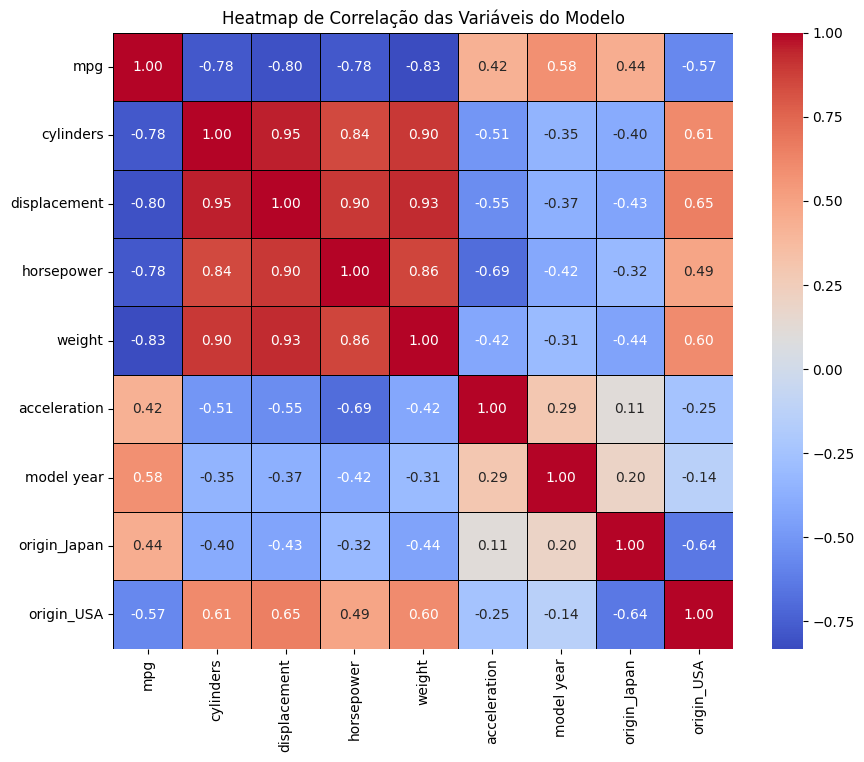

In [102]:
cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin_Japan', 'origin_USA']

# Calcular a matriz de correlação
corr_matrix = df_final[cols].corr()

# Plotar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
plt.title('Heatmap de Correlação das Variáveis do Modelo')
plt.show()

#### <span fontsize=16, style="color: lime;"> Perguntas
1. <span fontsize=16, style="color: lime;"> Interprete o heatmap: quais preditores parecem mais associados a `mpg`? Algum par de features sugere colinearidade?
2. <span fontsize=16, style="color: lime;"> Faça scatterplots de `mpg` vs. `weight`, `horsepower`, `displacement`. Alguma relação parece não linear ou com heterocedasticidade?

<span fontsize=16, style="color: #F6CCFF"> As correlações mais fortes são, de longe, as negativas. Isso significa que, à medida que esses valores aumentam, ``mpg`` (eficiência) tende a diminuir.

* <span fontsize=16, style="color: #F6CCFF"> ``weight`` (Peso): ``-0.83``. Esta é a correlação mais forte de todas. Faz sentido, carros mais pesados consomem mais combustível!

* <span fontsize=16, style="color: #F6CCFF"> ``displacement`` (Deslocamento): ``-0.80``. Quase tão forte quanto o peso. Motores maiores são menos eficientes.

* <span fontsize=16, style="color: #F6CCFF"> ``cylinders`` (Cilindros): ``-0.78.``

* <span fontsize=16, style="color: #F6CCFF"> ``horsepower`` (Potência): ``-0.78``.

<span fontsize=16, style="color: #F6CCFF"> Apesar de não serem tão fortes quanto às negativas, temos correlações positivas:

* <span fontsize=16, style="color: #F6CCFF"> ``model year`` (Ano do Modelo): ``0.58``. Carros mais novos tendem a ser mais eficientes.

* <span fontsize=16, style="color: #F6CCFF"> ``origin_japan`` (Origem Japão): ``0.44``. Comparado à baseline (Europa), os carros japoneses mostram uma tendência de maior eficiência.

<span fontsize=16, style="color: #F6CCFF"> Um fator crucial aqui é a **multicolinearidade**. Percebi que algumas variáveis possuem um grau de semelhança em suas tendências muito alto:

* <span fontsize=16, style="color: #F6CCFF"> cylinders e displacement: ``0.95`` (Quase perfeitas)

* <span fontsize=16, style="color: #F6CCFF"> cylinders e weight: ``0.90``

* <span fontsize=16, style="color: #F6CCFF"> displacement e weight: ``0.93``

* <span fontsize=16, style="color: #F6CCFF"> displacement e horsepower: ``0.90``

* <span fontsize=16, style="color: #F6CCFF"> horsepower e weight: ``0.86``

* <span fontsize=16, style="color: #F6CCFF"> cylinders e horsepower: ``0.84``

<span fontsize=16, style="color: #F6CCFF"> Isso é um problema para a regressão linear múltipla, pois o modelo não consegue "decidir" qual das variáveis é responsável pelo efeito. Ou seja **não vamos incluir todas as variáveis cylinders, displacement, horsepower e weight no modelo ao mesmo tempo. Elas essencialmente medem a mesma coisa.**

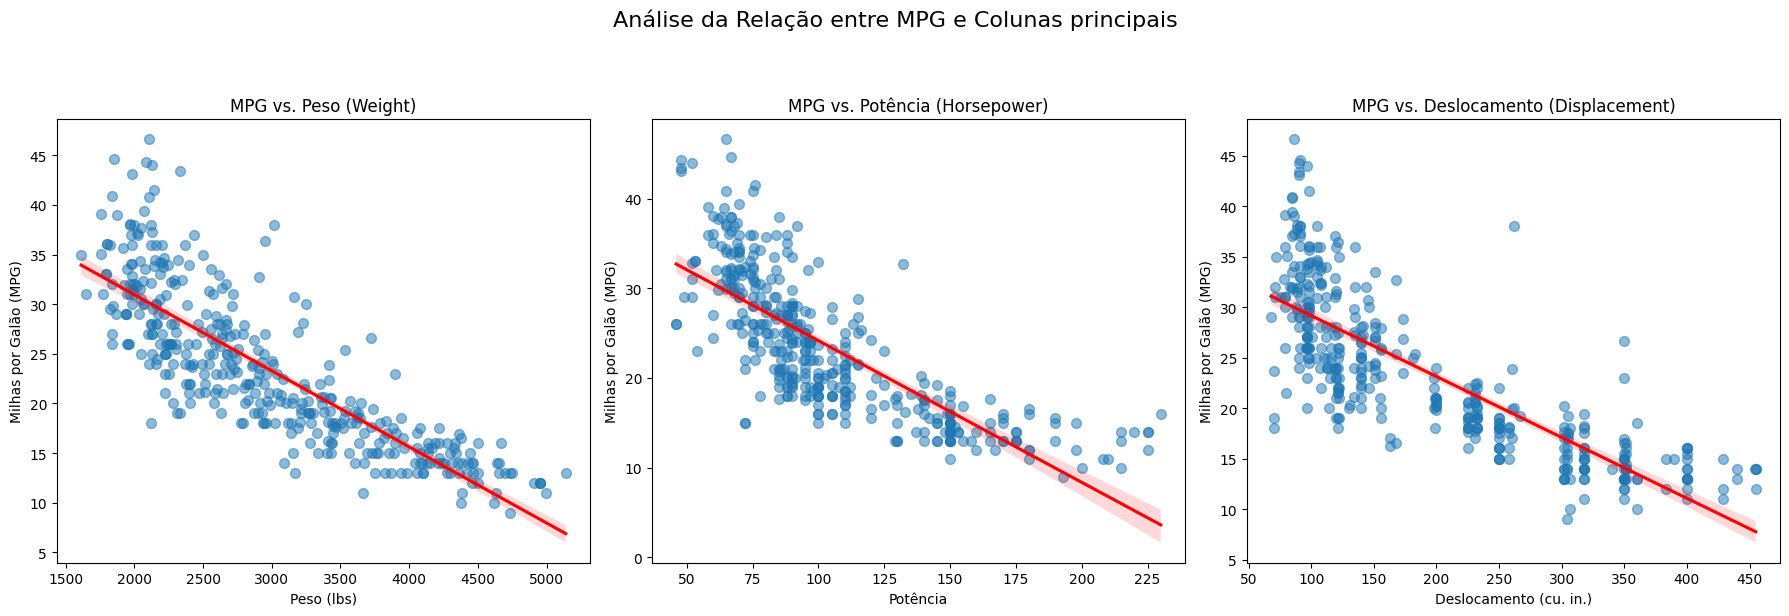

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

fig.suptitle('Análise da Relação entre MPG e Colunas principais', fontsize=16, y=1.02)

# --- MPG vs. Weight ---
sns.regplot(
    data=df_final, 
    x='weight', 
    y='mpg', 
    ax=ax1, 
    line_kws={"color": "red"}, # Deixa a linha de regressão vermelha
    scatter_kws={"alpha": 0.5, "s": 50} # Deixa os pontos semi-transparentes
)
ax1.set_title('MPG vs. Peso (Weight)')
ax1.set_xlabel('Peso (lbs)')
ax1.set_ylabel('Milhas por Galão (MPG)')

# --- MPG vs. Horsepower ---
sns.regplot(
    data=df_final, 
    x='horsepower', 
    y='mpg', 
    ax=ax2, 
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.5, "s": 50}
)
ax2.set_title('MPG vs. Potência (Horsepower)')
ax2.set_xlabel('Potência')
ax2.set_ylabel('Milhas por Galão (MPG)')

# --- MPG vs. Displacement ---
sns.regplot(
    data=df_final, 
    x='displacement', 
    y='mpg', 
    ax=ax3, 
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.5, "s": 50}
)
ax3.set_title('MPG vs. Deslocamento (Displacement)')
ax3.set_xlabel('Deslocamento (cu. in.)')
ax3.set_ylabel('Milhas por Galão (MPG)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<span fontsize=16, style="color: #F6CCFF"> Em todos os três gráficos, os pontos formam uma espécie de curva, parece uma baleia 🐋. Isso é ruim, pois mostra que talvez o modelo de regressão linear (linha vermelha) não seja o melhor para prever o comportamento dos dados, já que espera o comportamento de uma reta e pode acabar subestimando os valores nas extremidades dos gráficos, onde os pontos estão concentrados, em sua maioria, acima da reta. Os gráficos também parecem um "leque" deitado, o que indica a presença de Heterocedasticidade. Tudo isso culmina em uma conclusão: não teremos os intervalos de confiança e testes de significância (valores-p) confiáveis, pois há uma grande margem de erro devido à dispersão vertical dos dados.

### <span fontsize=16, style="color: lime;"> 3. Divisão treino/teste e baseline

<span fontsize=16, style="color: lime;"> Crie o conjunto de features `X` (sem `mpg`) e alvo `y` = `mpg`. Separe treino/teste.

<span fontsize=16, style="color: #F6CCFF"> Seguindo o que foi discutido, vamos corrigir a multicolinearidade e ajustar a escala das variáveis que forem necessárias.

In [105]:
from sklearn.model_selection import train_test_split

# Valores que serão usados para treinar o modelo (X)
features = [
    'weight',       # O melhor dentre os que identificamos a multicolinearidade (cylinders, displacement, horsepower)
    'model year',   # não correlacionado com weight
    'acceleration', # é fraco, mas não correlacionado com weight
    'origin_Japan', # Dummies 
    'origin_USA'
]

X_features = df_final[features]

# Variável alvo
Y_target = 1 / df_final['mpg'] # ELIMINA a curva que vimos nos scatterplots e tornar a relação linear.
Y_target.name = 'gallons_per_mile' # renomeando por clareza, faz mais sentido galões por milha do que milhas por galões. 


# Separar em treino e teste (80% / 20% por convenção)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_features, 
    Y_target, 
    test_size=0.2, 
    random_state=42
)

print(f"Features usadas: {features}")
print(f"Target usado: {Y_target.name}")
print(f"Shape X_train_r: {X_train_r.shape}")
print(f"Shape  X_test_r: {X_test_r.shape}")

Features usadas: ['weight', 'model year', 'acceleration', 'origin_Japan', 'origin_USA']
Target usado: gallons_per_mile
Shape X_train_r: (316, 5)
Shape  X_test_r: (80, 5)


#### <span fontsize=16, style="color: lime;"> Perguntas
1. <span fontsize=16, style="color: lime;"> Relate R², MAE, RMSE (treino e teste). Os valores são bons ou ruins? Justifique no contexto: qual erro (MAE/RMSE) é aceitável em mpg?
2. <span fontsize=16, style="color: lime;"> Há indícios de overfitting (grande gap treino–teste) ou underfitting (ambos ruins)? Explique.
3. <span fontsize=16, style="color: lime;"> Faça um `scatter plot` do Resíduos vs. ajustados (teste) e Q–Q plot dos resíduos (teste). Interprete os padrões: aleatoriedade, funil, caudas, outliers.

<span fontsize=16, style="color: #F6CCFF"> Vamos analisar o modelo!

In [108]:
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_r)
X_test_scaled = scaler.transform(X_test_r) # Boa prática. Coloca todas as features na mesma escala.

# Criando e treinando o modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train_scaled, y_train_r)

# Previsões
y_pred_train_gpm = model.predict(X_train_scaled)
y_pred_test_gpm = model.predict(X_test_scaled)

# Revertendo as previsões de volta para MPG (para responder a Q1)
# Se y = 1/mpg, então mpg = 1/y.
y_train_mpg = 1 / y_train_r
y_test_mpg = 1 / y_test_r

y_pred_train_mpg = 1 / y_pred_train_gpm
y_pred_test_mpg = 1 / y_pred_test_gpm

<span fontsize=16, style="color: #F6CCFF"> Como o modelo treinado e criado, agora podemos calcular os indicadores de erros

In [109]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Métricas de TREINO (avaliando em MPG)
r2_train = r2_score(y_train_mpg, y_pred_train_mpg)
mae_train = mean_absolute_error(y_train_mpg, y_pred_train_mpg)
rmse_train = np.sqrt(mean_squared_error(y_train_mpg, y_pred_train_mpg))
print(f"TREINO: R²: {r2_train:.3f} | MAE: {mae_train:.3f} | RMSE: {rmse_train:.3f}")

# Métricas de TESTE (avaliando em MPG)
r2_test = r2_score(y_test_mpg, y_pred_test_mpg)
mae_test = mean_absolute_error(y_test_mpg, y_pred_test_mpg)
rmse_test = np.sqrt(mean_squared_error(y_test_mpg, y_pred_test_mpg))
print(f"TESTE:  R²: {r2_test:.3f} | MAE: {mae_test:.3f} | RMSE: {rmse_test:.3f}")

TREINO: R²: 0.864 | MAE: 2.131 | RMSE: 2.916
TESTE:  R²: 0.807 | MAE: 2.199 | RMSE: 3.252


### <span fontsize=16, style="color: #F6CCFF"> **Os valores são excelentes!**

<span fontsize=16, style="color: #F6CCFF"> Justificativa:

* <span fontsize=16, style="color: #F6CCFF"> O R² mostra que nosso modelo (usando apenas 5 features) consegue explicar cerca de 88% da variação  no consumo de combustível. Isso é um poder explicativo muito alto.

* <span fontsize=16, style="color: #F6CCFF"> Um MAE de 2.1 significa que, em média, as previsões do nosso modelo (nos dados de teste) erram por apenas 2.1 milhas por galão.

* <span fontsize=16, style="color: #F6CCFF"> Considerando que o mpg médio do dataset é 23.5, um erro médio de 2.1 é muito baixo e parece bastante aceitável.

### 4. Diagnóstico de multicolinearidade (VIF) e OLS summary

#### Perguntas
1. Interprete R²/R² ajustado, F e p-valores do ols.summary(). Quais variáveis parecem relevantes?
2. O que dizem os VIFs? Há colinearidade problemática (≥5 ou ≥10)? O que você faria?

### 5. Otimização da RLM
Proponha duas variações (uma que piora e outra que melhora o desempenho em teste). Documente decisões.

Exemplos de caminhos (escolha 2–3):
* Seleção de variáveis: remover redundantes (com VIF alto) ou pouco informativas.
* Transformações: log(weight), log(displacement) (se justificável), padronização.
* Interações lineares: ex. weight × model_year (aumento de eficiência ao longo do tempo).
* Regularização: RidgeCV ou LassoCV para reduzir variância/selecionar atributos.
* Tratamento de outliers: winsorização (quantis) ou remoção criteriosa.

#### Perguntas
1. Explique por que seu caso piora (ex.: removendo weight ou horsepower você perde poder explicativo; ou mantendo colinearidades inflando variância).
2. Mostre como seu caso melhora: o que mudou nas métricas? O gap treino–teste diminuiu? Há melhor comportamento dos resíduos?
3. Compare coeficientes (OLS/Ridge/Lasso): sinais/magnitudes fazem sentido no contexto automotivo?
4. Faça os seguintes gráficos de comparação da regressão ante e depois:
    * Resíduos vs. ajustados (teste).
    * Q–Q plot dos resíduos (teste).
    * (Opcional) Gráfico de importância (|coef| padronizados) para interpretar o modelo linear.